<a href="https://colab.research.google.com/github/AguaClara/Textbook/blob/master/Colab/AC_Textbook_Chapter10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chapter 10: Filtration

This is a corresponding Colab document for the tenth chapter of the AguaClara textbook.

In [ ]:
!pip install aguaclara

#Example: Stacked Rapid Sand Filters

In [ ]:
from aguaclara.core.units import unit_registry as u
import numpy as np

Q_Filter = 8 * u.L/u.s
V_filter_backwash = 11 * u.mm/u.s
A_Filter = Q_Filter/V_filter_backwash
W_Filter = np.sqrt(A_Filter).to(u.m)
print('The width of a filter designed to treat ',Q_Filter,' is ', W_Filter,'.')

#Filtration Theory and Future Work:



Floc size and velocity gradient calculations:

In [ ]:
import aguaclara.core.physchem as pc
from aguaclara.core.units import unit_registry as u
import aguaclara.research.floc_model as fm
import aguaclara.core.constants as co

import numpy as np
import matplotlib.pyplot as plt

N_layers = 6
v_filter_backwash = 11 * u.mm/u.s
v_a = v_filter_backwash/N_layers
Porosity = 0.4
D_sand = 0.5 * u.mm
# the following is just a guess at pore size
D_pore = 0.2 * D_sand
Temperature = 20 * u.degC
L = 20 * u.cm
Q_waterfall = 20 *u.L/u.s
v_waterfall=(np.sqrt(co.GRAVITY*2*40*u.cm)).to(u.m/u.s)
v_waterfall
#use continuity to get diameter of waterfall
D_waterfall = (np.sqrt(Q_waterfall/v_waterfall *4/np.pi)).to(u.cm)
D_waterfall
Pi_JetRound = 0.08
G_Max_waterfall = (v_waterfall*np.sqrt(Pi_JetRound*v_waterfall/(pc.viscosity_kinematic(Temperature)*D_waterfall))).to(u.Hz)
print('The maximum velocity gradient in the plunging jet in the filter inlet box is ',G_Max_waterfall,'.')
# now estimate the size of this floc
EDR_waterfall = (G_Max_waterfall**2*pc.viscosity_kinematic(Temperature)).to(u.mW/u.kg)
EDR_waterfall



# Calculate maximum diameter of flocs leaving the clarifier
D_floc= fm.diam_floc_vel_term(0*u.mg/u.L,10*u.mg/u.L,fm.PACl,fm.Clay,fm.DIM_FRACTAL, 0.12*u.mm/u.s,20*u.degC)
print('The maximum diameter of flocs leaving the clarifier is',D_floc.to(u.um),'.')

v_graph = np.linspace(0.1, 100, 500) * u.mm/u.s

fig, ax = plt.subplots()
ax.plot(v_graph,(pc.headloss_ergun(v_graph, D_sand, Temperature, Porosity, L)/L).to(u.dimensionless),'-')
ax.set(xlabel='approach velocity (mm/s)')
ax.set(ylabel='head loss per m')
plt.show()

In [ ]:
# Need to use a root finding method here because f_phi is a function of velocity
# Will use a graphical solution for now

fig, ax = plt.subplots()
ax.plot(v_graph,pc.g_cs_ergun(v_graph, D_sand, Temperature, Porosity),'-')
ax.set(xlabel='approach velocity (mm/s)')
ax.set(ylabel='velocity gradient (Hz)')
plt.show()

In [ ]:
#from the graph above we'd need an approach velocity of about 80 mm/s to achieve a G of 10,000 Hz.
v_inject = 80*u.mm/u.s
(v_inject/v_a).to(u.dimensionless)
injection_port_spacing = 10 * u.cm
injection_port_width =     (injection_port_spacing/(v_inject/v_a)).to(u.mm)
print('The injection port width would be ',injection_port_width,'.')
print('The injection velocity would be ',v_inject.to(u.mm/u.s),'.')

In [ ]:
#This is for an inlet that serves 2 layers (up and down)
v_filter = (11 * u.mm/u.s)/N_layers*2
S_branch = 10 * u.cm
v0 = 80 * u.mm/u.s
r0 = (2*v_filter/v0 * S_branch/(2*np.pi)).to(u.mm)
r0

#create coefficients for the constant terms in the equation
a0 = v0 * r0 /(2*co.GRAVITY*D_sand)
a1 = (300*pc.viscosity_kinematic_water(Temperature)*(1-Porosity)**2)/(D_sand*Porosity**3)
a2 = 3.5*(1-Porosity)* v0 * r0/Porosity**3
r1 = S_branch/(2*np.pi)
r1
#create an array of r values with each value centered in the ring that it represents. #We will use simple r_array.to_base_units()
n_points = 10000 #np.multiply(r_array.to_base_units(),r_array.to_base_units()))
dr = ((r1-r0)/(n_points)).to(u.mm)
r_array = np.linspace((r0).to(u.mm),(r1).to(u.mm),n_points)
y_array = (a0*(np.divide(a1,r_array) + np.divide(a2,np.multiply(r_array,r_array)))).to(u.dimensionless)#Use the trapezoidal rule to integrate
#need to reattach units to np.trapz.
hf_inlet = np.trapz(y_array,x=r_array, dx = dr).magnitude
print('The head loss through the sand between the injection point and where it reaches the filtration velocity is ', hf_inlet * (1/10) * (u.cm))

#Filtration Design Solution:

DC Stacked Rapid Sand Filtration:

In [ ]:
import aguaclara.core.physchem as pc
from aguaclara.core.units import unit_registry as u
import aguaclara.research.floc_model as fm
import aguaclara.core.constants as co

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
flow_plant = 12 * u.L / u.s
density_sand = 2650 * u.kg / u.m**3
k_Kozeny = 5
H_filter_layer = 20 * u.cm
N_filter_layer = 6


#We will use 20 deg C as the typical operating temperature. Honduras is quite warm.
T_design = 20*u.degC


# Notes on Uniformity Coefficient and Effective size from http://www.clean-water-for-laymen.com/sand-sieve.html

#Effective Size (ES) – This is defined as the size of screen opening that will pass 10% of the sand sample (see more explanation below)
#Uniformity Coefficient (UC) – This is defined as a ratio and is calculated as the size opening that will just pass 60% of the sand (d60 value) divided by the size opening that will just pass 10% of the sand sample (d10 value).
#ES is basically a value describing the average size of sand grains in a sand sample.
#UC is basically a value describing the range of grain sizes present in a sample

D_filter_sand_ES = 0.5 * u.mm
UC_filter_sand = 1.6
porosity_filter_sand = 0.4
V_filter_backwash = 11 * u.mm / u.s

1) Calculate the total sand depth of all 6 sand layers:

In [ ]:
H_filter_sand_total = (H_filter_layer * N_filter_layer).to(u.m)
print('The total depth of the filter sand is', H_filter_sand_total,'.')

2) Calculate the diameter that is larger than 60% of the sand (D60 of the filter sand).

In [ ]:
D60_filter_sand = D_filter_sand_ES * UC_filter_sand
print('The D60 for the sand grain size is', D60_filter_sand,'.')

3) What is the total filter bed plan view area for both filters in Tamara?

In [ ]:
A_filter_total = (flow_plant / V_filter_backwash).to(u.m**2)
print('The filter bed plan view area is ',A_filter_total,'.')

4) What is the velocity of water through a filter during filtration? Recall that the flow through the filter is the same in filter and backwash modes.

In [ ]:
V_filter = V_filter_backwash / N_filter_layer
print('The filtration velocity is', V_filter,'.')

5) Create a function to calculate the head loss through the filter at the beginning of filtration with a clean filter bed. Then use that function to find the head loss through the clean bed of the Tamara filter. Assume that each flow path receives the same flow.

Recall: - If you have flow paths in parallel, the head loss is NOT the sum of the head loss in each path. - Instead, the head loss in each path is the same as the total head loss.

In [ ]:
def headloss_kozeny(PorosityFilterSand, D60_filter_sand, VelocityFilter, DepthFilter):

    return (36*k_Kozeny*((1 - PorosityFilterSand)**2 / PorosityFilterSand**3) * (
            pc.viscosity_kinematic_water(T_design) * VelocityFilter)/(co.GRAVITY * D_filter_sand_ES**2)* DepthFilter).to(u.cm)

hl_filter_clean = headloss_kozeny(porosity_filter_sand, D60_filter_sand, V_filter, H_filter_layer)
print('The headloss through the clean filter sand is', hl_filter_clean,'.')

6) Create a function to estimate the minimum fluidization velocity for this filter bed. Then use that function to find the minimum fluidization velocity of the Tamara filter. Fluidization occurs at the beginning of backwash as all of the water flows through the bottom inlet. Note that this is not the actual velocity used for backwashing the sand.

In [ ]:
def velocity_backwash_min(porosity_sand, D60_filter_sand,T):
    return ((porosity_sand**3 * co.GRAVITY * D60_filter_sand**2) / (
            36 * k_Kozeny * pc.viscosity_kinematic_water(T) * (1 - porosity_sand)) * (
            density_sand / pc.density_water(T)-1)).to(u.mm/u.s)

print('The minimum fluidization velocity for this filter bed is', velocity_backwash_min(porosity_filter_sand, D60_filter_sand,T_design),'.')

7) First, plot the minimum backwash velocity as a function of water temperature from 0°C to 30°C. Then use your plot to answer the following question: if you have a water treatment plant with a single filter and there is a drought that is reducing flow to the plant, when should you backwash the filter? Should you backwash when the water is coolest or when the water is warmest?

In [ ]:
T_graph=np.linspace(0,30,50)*u.degC
ypoints = velocity_backwash_min(porosity_filter_sand, D60_filter_sand,T_graph)
fig, ax = plt.subplots()
ax.plot(T_graph,ypoints,'-')

ax.set(xlabel=r'Temperature (°C)')
ax.set(ylabel='Minimum backwash velocity')
plt.show()

8) What is the residence time of water in the filter during backwash, when the bed is fluidized? You may assume the sand bed expansion ratio is 1.3.

In [ ]:
Pi_filter_backwash_expansion = 1.3
t_res_filter_backwash = ((porosity_filter_sand * H_filter_sand_total + (
                            Pi_filter_backwash_expansion - 1) * H_filter_sand_total
                           ) / V_filter_backwash).to(u.s)


print('The residence time in the fluidized bed during backwash is', t_res_filter_backwash,'.')

9) Our next overall goal is to determine the ratio of water wasted in a Stacked Rapid Sand (StaRS) Filter to water treated in a StaRS. Given that the backwash water that ends up above the filter bed never returns to the filter it isn’t necessary to completely clear the water above the filter bed during a backwash cycle. Therefore we anticipate that backwash can be ended after approximately 3 expanded bed residence times. In addition it takes about 1 minute to initiate backwash by lowering the water level above the filter bed.

To start, estimate the time between beginning backwash and finishing the cleaning of the bed.

In [ ]:
t_filter_backwash_drain = 1 * u.min
t_filter_backwash = (t_res_filter_backwash * 3 + t_filter_backwash_drain).to(u.s)

print('The time to backwash the filter is', t_filter_backwash,'.')

10) Estimate the total depth of water that is wasted while backwash is occuring.

In [ ]:
H_filter_backwash_water = (V_filter_backwash * t_filter_backwash).to(u.m)

print('The total depth of water that is wasted is', H_filter_backwash_water,'.')

11) Estimate the total depth of water that is lost due to refilling the filter box at the end of backwash plus the slow refilling to the maximum dirty bed height. You may ignore the influence of plumbing head loss and you may assume that the dirty bed head loss is about 40 cm. The water level in the filter during backwash is lower than the water level at the end of filtration by both the head loss during backwash AND the head loss at the end of filtration. There is also an additional 20 cm of lost water that is required for the hydraulic controls.

In [ ]:
hl_filter_final = 40 * u.cm
H_hydraulic_controls = 20*u.cm
H_filter_backwash_water_refill = H_filter_sand_total + H_hydraulic_controls + hl_filter_final

print('The total depth of water that is lost due to refilling the filter box is', H_filter_backwash_water_refill)

12) Now calculate the total length (or depth) of water that is wasted due to backwash by adding the two previous lengths. The length found in problem 10 represents water wasted while backwash is occurring, while the length in problem 11 represents the water lost in the transition to and from backwash.

In [ ]:
H_filter_backwash_water_wasted = H_filter_backwash_water + H_filter_backwash_water_refill
print('The depth of the water that is wasted due to backwash is', H_filter_backwash_water_wasted)

13) Assume that the filter is backwashed every 12 hours. This means that the filter is producing clean water for 12 hours before it need to be backwashed. What is the total height (or length) of water that would be treated by the filter during this time? This length when multiplied by the area of the filter would give the total volume of water processed by a filter.

In [ ]:
t_filter_cycle = 12 * u.hr
H_water_filtered_per_cycle = (t_filter_cycle * V_filter_backwash).to(u.m)
print('The height of water that would enter the filter in 12 hours is', H_water_filtered_per_cycle)

14) Finally, what is the ratio of water lost due to backwash and related water level changes in the filter box to water treated?

In [ ]:
Pi_water_wasted = (H_filter_backwash_water_wasted / H_water_filtered_per_cycle)
print('The fraction of the total water that is lost due to backwash is', Pi_water_wasted)

15) Now we will evaluate the very first data set from a full scale SRSF. The performance data given below is the settled water turbidity and then the filtered water turbidity during one filter run. The time step is 5 minutes. Plot pC* for the filter as well as effluent turbidity as a function of time on two separate graphs.

In [ ]:
filter_influent = np.array([7.06201,7.14465,7.00537,6.33032,5.4502,4.98511,4.64221,4.23853,3.93707,3.72717,3.67126,3.55866,3.55292,3.45593,3.48163,3.50226,3.45093,3.50232,3.41095,3.55341,3.46643,3.50732,3.49146,3.51208,3.487,3.58893,3.54315,3.61469,3.58429,3.55835,3.72723,3.7829,3.74201,3.82398,3.74725,3.83423,3.72717,3.72705,3.87079,3.77338,3.70148,3.74762,3.76227,3.58875,3.63477,3.67566,3.52789,3.59296,3.66577,3.51709,3.63965,3.57843,3.47546,3.66016,3.58386,3.53259,3.57886,3.51392,3.63983,3.64972,3.64606,3.49121,3.51691,3.5119,3.61414,3.5835,3.46558,3.63965,3.60962,3.50147,3.51678,3.46039,3.49133,3.48566,3.50104,3.5943,3.47778,3.53766,3.55811,3.50635,3.42535,3.48077,3.54242,3.55274,3.59369,3.48596,3.53296,3.51746,3.45056,3.59387,3.5426,4.26868,3.99201,3.45569,3.86975,3.54407,3.49097,3.9823,3.58325,3.77789,3.70111,3.59839,4.09424,3.56769,3.83325,3.76019,3.49121,4.52917,3.63037,4.21228,3.60858,4.72827,4.00757,3.71674,3.87647,3.8288,3.44067,3.74219,3.64941,3.87439,3.79327,4.10486,4.16638,3.84418,4.11792,3.46082,3.71661,3.5061,3.48596,4.42175,3.57806,4.01294,3.63965,3.80408,3.60431,3.67572,3.61981,3.66022,3.67554,3.46076,3.72669,3.56287,3.66003,3.60004,3.4812,3.55823,6.19641,3.74146,3.88025,4.18713,4.27881,3.6496,3.45111,3.8656,3.90106,3.68597,3.66101,3.88513,3.74652,3.70123,3.79828,3.84369,3.59418,3.60968,3.49127,3.45081,3.40424,3.35852,3.32788,3.29211,3.21008,3.79279,])*u.NTU
filter_effluent = np.array([0.926376,0.645981,0.69725,0.625855,0.600449,0.472694,0.381546,0.340439,0.309883,0.289848,0.27813,0.254097,0.249432,0.253769,0.203117,0.253891,0.34063,0.223385,0.365952,0.264389,0.259193,0.340576,0.279671,0.309776,0.304878,0.279404,0.299896,0.340294,0.25399,0.350731,0.34053,0.487877,0.391518,0.309715,0.360901,0.442352,0.30967,0.391251,0.457253,0.447685,0.386322,0.549149,0.33036,0.426437,0.513458,0.279022,0.462692,0.589768,0.381073,0.532669,0.538529,0.350472,0.559036,0.51828,0.462578,0.594772,0.47242,0.538681,0.605087,0.402168,0.538818,0.66658,0.447243,0.574585,0.691544,0.513382,0.655701,0.655884,0.605408,0.666153,0.599976,0.651047,0.702515,0.92572,0.90535,0.732117,0.605026,0.849335,0.691925,0.584976,0.803314,0.783569,0.706787,0.783066,0.640701,0.732269,0.803497,0.625458,0.625687,1.00089,1.03265,1.00687,0.834213,0.732224,0.859665,0.559174,1.08862,0.93634,0.722717,0.966141,1.03278,0.890366,0.874756,0.813675,0.864746,0.874863,0.625504,0.874847,0.889893,0.931473,0.880112,1.30231,0.813965,0.961502,0.966324,0.839432,0.889969,0.930618,1.20074,0.93631,0.951584,0.78331,0.961609,0.996796,0.940994,0.966675,1.04788,0.951645,0.966888,1.01251,0.96167,1.0076,0.900436,0.996628,1.12949,0.910263,1.03256,1.04788,0.997604,1.05817,1.05801,1.06311,1.05805,1.00711,1.05811,1.11896,1.06299,1.07318,0.966049,1.07343,1.09918,1.15497,1.07303,1.13937,1.12402,1.155,1.15436,1.2056,1.14954,1.17526,1.15457,1.20569,1.17517,1.0376,0.915253,0.935471,0.884979,0.89035,0.940781,0.885071,0.874817,0.828796])*u.NTU


t_delta = 5 * u.min
t_end = np.shape(filter_effluent)[0]
t_data = np.arange(0,t_end)*t_delta
c_dim = np.divide(filter_effluent,filter_influent)
filter_pc = -np.log10(c_dim)
fig, ax = plt.subplots()
ax.plot(t_data.to(u.hour),filter_pc)
ax.set(xlabel='Filter run time (hrs)')
ax.set(ylabel='pC*')
plt.show()

fig, ax = plt.subplots()
ax.plot(t_data.to(u.hour),filter_effluent)
ax.set(xlabel='Filter run time (hrs)')
ax.set(ylabel='Effluent turbidity (NTU)')
plt.show()

16) How many kg of suspended solids per square meter of filter were removed during this filter run. Use the plan view area for the filter (don’t multiply by the number of layers)

In [ ]:
M_filter_solids = (np.sum((filter_influent - filter_effluent) * (
                    flow_plant * t_delta)/ A_filter_total)
                     ).to(u.kg/u.m**2)

print('The mass of the suspended solids removed is', M_filter_solids)

17) Another useful way to express the solids capacity of the filter is to calculate the turbidity removed the run time and then express the results with units of NTU hrs. What was the capacity of the filter in NTU hrs?

In [ ]:
solids_capacity_filter = (np.sum((filter_influent-filter_effluent) * t_delta)).to(u.NTU * u.hr)


print('The filter capacity is',solids_capacity_filter,)

18) How long was the filter run?

In [ ]:
t_filter_cycle = t_data[np.size(t_data)-1]
print('The filter was run for', t_filter_cycle.to(u.hour))

19) What is the total volume of pores per square meter (plan view area) of StarS filter bed (includes all 6 layers) (in L/m^2)?

In [ ]:
volume_filter_pores = (H_filter_sand_total * porosity_filter_sand).to(u.L/u.m **2)
print('The total volume of pores is', volume_filter_pores)

20) The next step is to estimate the volume of flocs per plan view area of the filter. Assume the density of the flocs being captured by the filter are approximated by the density of flocs that have a terminal velocity of 0.10 mm/s (slightly less than the capture velocity of the plate settlers). (see slides in flocculation notes for size of the floc and then density of that floc. I’ve provided this value below to simplify the analysis

In [ ]:
density_floc = pc.density_water(T_design) + 100 * u.kg/u.m**3
density_clay = 2650 * u.kg/u.m**3

In [ ]:
vol_floc = ((M_filter_solids *pc.density_water(T_design)/(density_floc-pc.density_water(T_design))) *
            ((1/pc.density_water(T_design))-1/density_clay)).to(u.l / u.m **2)
print('The volume of the flocs per plan view area is', vol_floc)

21) What percent of the filter pore volume is occupied by the flocs? This fraction of pore space occupied is quite small and suggests that much of the filter bed has a very low particle concentration at the end of a filter run.

In [ ]:
Pi_flocvolume_porevolume = (vol_floc / volume_filter_pores)

print('The fraction of filter pore volume that is occupied by flocs is', Pi_flocvolume_porevolume)

#Filter constriction hypothesis:

In [ ]:
hl_filter_final = 50 * u.cm
hl_constriction = hl_filter_final-hl_filter_clean

print('The minor loss contribution is', hl_constriction)

In [ ]:
vol_filter_sand_grain = D60_filter_sand**3 * np.pi/6
vol_filter_sand_grain_and_pore = vol_filter_sand_grain / (1 - porosity_filter_sand)
N_sand_grains = 1 /(vol_filter_sand_grain_and_pore)

print('There are this many sand grains in a cubic millimeter', N_sand_grains.to(1/u.mm**3))

In [ ]:
L_grain_separation = (vol_filter_sand_grain_and_pore **(1/3)).to(u.mm)

print('The distance between flow constriction is', L_grain_separation)

In [ ]:
N_constriction = (H_filter_layer/L_grain_separation).to(u.dimensionless)

print('A water molecule flows through', N_constriction,'constriction through the StaRS filter')

In [ ]:
hl_per_constriction = (hl_constriction / N_constriction).to(u.mm)
print('The head loss per constriction is', hl_per_constriction)

In [ ]:
V_pore = V_filter / porosity_filter_sand
V_constriction = ((2 * co.GRAVITY * hl_per_constriction)**(1/2) + V_pore).to(u.mm /u.s)

print('The velocity in the constriction is', V_constriction)

In [ ]:
N_pore_per_area = 1 / L_grain_separation**2
flow_per_pore = (V_filter/ N_pore_per_area).to(u.microliter/u.s)

print('The flow rate through each pore is', flow_per_pore)

In [ ]:
Pi_vena_contracta = 0.62
A_constriction = flow_per_pore / V_constriction/Pi_vena_contracta
D_constriction = pc.diam_circle(A_constriction)
print('The inner diameter of the flow constriction created by the flocs is', D_constriction.to(u.micrometer))

In [ ]:
D_clay = 7 * u.micrometer

#create an array of floc sizes from clay diameter up to the diameter of the constriction

def D_floc(D_constriction):
    return (np.linspace(D_clay.to(u.micrometer), D_constriction.to(u.micrometer)))


#below is an estimate of the floc removal efficiency as a function of the floc size
def c_star_constriction(D_constriction):
    return (((D_constriction - D_floc(D_constriction))/ D_constriction)**2)

c_star = c_star_constriction(D_constriction)
fig, ax = plt.subplots()
ax.plot(D_floc(D_constriction),c_star)
ax.set(xlabel='Particle diameter(micrometer)')
ax.set(ylabel='Fractional remaining')
plt.show()

# Chapter 11: Hydraulics

This Colab document corresponds to the eleventh chapter of the AguaClara textbook.

#Constants Needed To Run Snippets:

In [ ]:
!pip install aguaclara
import aguaclara.core.physchem as pc
import aguaclara.core.utility as uc
import aguaclara.core.pipes as pp
from aguaclara.core.units import unit_registry as u

import numpy as np
import matplotlib.pyplot as plt
#I played with the velocity gradient to get a reasonable head loss of 50 cm.
G_CS = 123 * u.Hz
density_clay = 2650 * u.kg/u.m**3
#From William's research the k for flocculator is 0.03. We need to confirm that this value is correct.
k = 0.03
# It isn't clear what value should be used for alpha
alpha = 0.5
# The following 3 values are estimates from Casey's floc blanket video.
C_infb = 40 * u.NTU
C_outfb = 1 * u.NTU
t_fb = 800 * u.s
k_fb = -1/t_fb*(np.log(C_outfb/C_infb))
C_out_f = (np.pi* density_clay/6 * (k_fb/(np.pi*alpha*k*G_CS))**(3/2)).to(u.NTU)

Gt = (3/2 * 1/(k*np.pi * alpha) * (np.pi/6 * density_clay/C_out_f)**(2/3)).to(u.dimensionless)
t_floc = 3/2 * 1/k_fb

Temp = 20 * u.degC

Floc_HL = (G_CS**2 * t_floc * pc.viscosity_kinematic(Temp)/u.standard_gravity).to(u.cm)

     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 209 kB 63.1 MB/s 
     |████████████████████████████████| 2.1 MB 45.1 MB/s 
     |████████████████████████████████| 109 kB 54.1 MB/s 
     |████████████████████████████████| 546 kB 75.3 MB/s 
  Created wheel for aguaclara: filename=aguaclara-0.2.10-py3-none-any.whl size=107244 sha256=9e71b95f889ee1ec0abcffb2c4596c01f37a6883996d4d17babe218611b7865b
  Stored in directory: /root/.cache/pip/wheels/a3/12/ef/53d591c580e122cb62a84cb2180ddba9ba03bb3dc85b19285e
Successfully built aguaclara


/usr/local/lib/python3.7/dist-packages/aguaclara/core/physchem.py:157: UserWarning: viscosity_kinematic is deprecated; use viscosity_kinematic_water instead.
  'viscosity_kinematic_water instead.', UserWarning)


#Example: Filter Inlet Channel with Rectangular Weir Flow Distribution

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


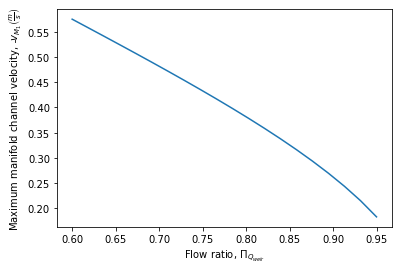

In [ ]:
def Inlet_Channel_V_Max(H_weir,Ratio_Flow):
  return (2 * np.sqrt(u.gravity*H_weir*(1-Ratio_Flow**(2/3))/(1+Ratio_Flow**(2/3)))).to(u.m/u.s)

Ratio_Q_graph = np.linspace(0.6,0.95,20)

H_weir = 5 * u.cm
v_graph = np.empty_like(Ratio_Q_graph) * u.m/u.s
for i in range(20):
  v_graph[i] = Inlet_Channel_V_Max(H_weir,Ratio_Q_graph[i])

plt.plot(Ratio_Q_graph,v_graph)
plt.xlabel(r'Flow ratio, $\Pi_{Q_{weir}}$')
plt.ylabel(r'Maximum manifold channel velocity, $ \bar v_{M_1} \left(\frac{m}{s} \right)$')
plt.show()